<a href="https://colab.research.google.com/github/GeorgeShmelin/Masterschool_time_series_Project_supermarket_favorita/blob/main/3_part_time_series__XGBoost_Hyperparameter_Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Save the trained model

In [ ]:
import os
import joblib

In [ ]:
import gc # Import the gc module
# gc.collect() are for rubbish collection — basically cleaning up memory that Python no longer needs

In [ ]:
# !pip install xgboost
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [ ]:
from hyperopt import STATUS_OK

In [ ]:
# pip install hyperopt
from hyperopt import hp

# Data download

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df_download = pd.read_csv('/content/drive/MyDrive/MasterSchool/MasterSchool_Python/Time_Series/Time_series_project/df_train_3.csv')
df_download.shape

(26307, 24)

This data has been already joined, encoded (mostly by One Hot Encoder) and filtered. Full path of the data download, cleaning and encoding using SQL is presented in https://github.com/GeorgeShmelin/MasterSchool_Python_Studies.git or https://colab.research.google.com/drive/1rxXgcs68TGxuIKV8dAk3dWDCgaQSfNbQ?usp=sharing

In [ ]:
df_download.sample(2)

,unit_sales,store_nbr,item_nbr,onpromotion,dcoilwtico,transferred,item_class,transactions,weighted_unit_sales,date,...,year_scaled,city_Daule,city_Guayaquil,city_Libertad,city_Playas,city_nan,items_family_BEVERAGES,items_family_CLEANING,items_family_GROCERY I,items_family_nan
22790,3.0,36,982726,0,51.17,0,3018,1849,3.0,2015-02-14,...,-2,0,0,1,0,0,0,1,0,0
2295,1.0,51,938436,0,100.32,0,3034,2088,1.0,2014-05-09,...,-3,0,1,0,0,0,0,1,0,0


In [ ]:
# Downcast numeric columns to smallest possible types
for col in df_download.select_dtypes(include=['int', 'float']).columns:
    if pd.api.types.is_integer_dtype(df_download[col]):
        df_download[col] = pd.to_numeric(df_download[col], downcast='integer')
    elif pd.api.types.is_float_dtype(df_download[col]):
        df_download[col] = pd.to_numeric(df_download[col], downcast='float')
        df_download[col] = pd.to_numeric(df_download[col], downcast='float')

In [ ]:
# del df_download['date']

In [ ]:
df_download.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26307 entries, 0 to 26306
Data columns (total 24 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   unit_sales              26307 non-null  float32
 1   store_nbr               26307 non-null  int8   
 2   item_nbr                26307 non-null  int32  
 3   onpromotion             26307 non-null  int8   
 4   dcoilwtico              26307 non-null  float32
 5   transferred             26307 non-null  int8   
 6   item_class              26307 non-null  int16  
 7   transactions            26307 non-null  int16  
 8   weighted_unit_sales     26307 non-null  float32
 9   date                    26307 non-null  object 
 10  month                   26307 non-null  int8   
 11  day                     26307 non-null  int8   
 12  week                    26307 non-null  int8   
 13  day_of_week             26307 non-null  int8   
 14  year_scaled             26307 non-null

In [ ]:
df_sxg = df_download.copy()

As illustrated in the graph presented here, the price of oil exhibits considerable volatility over the selected period. As explained in greater detail on my GitHub page, the findings of my previous research indicate that shopping activity in Ecuador is strongly influenced by the external factor of global oil prices. Therefore, accurate predictions of shopping trends are only feasible when social and geographic shopping areas are clustered, and the oil price factor is incorporated into the analysis.

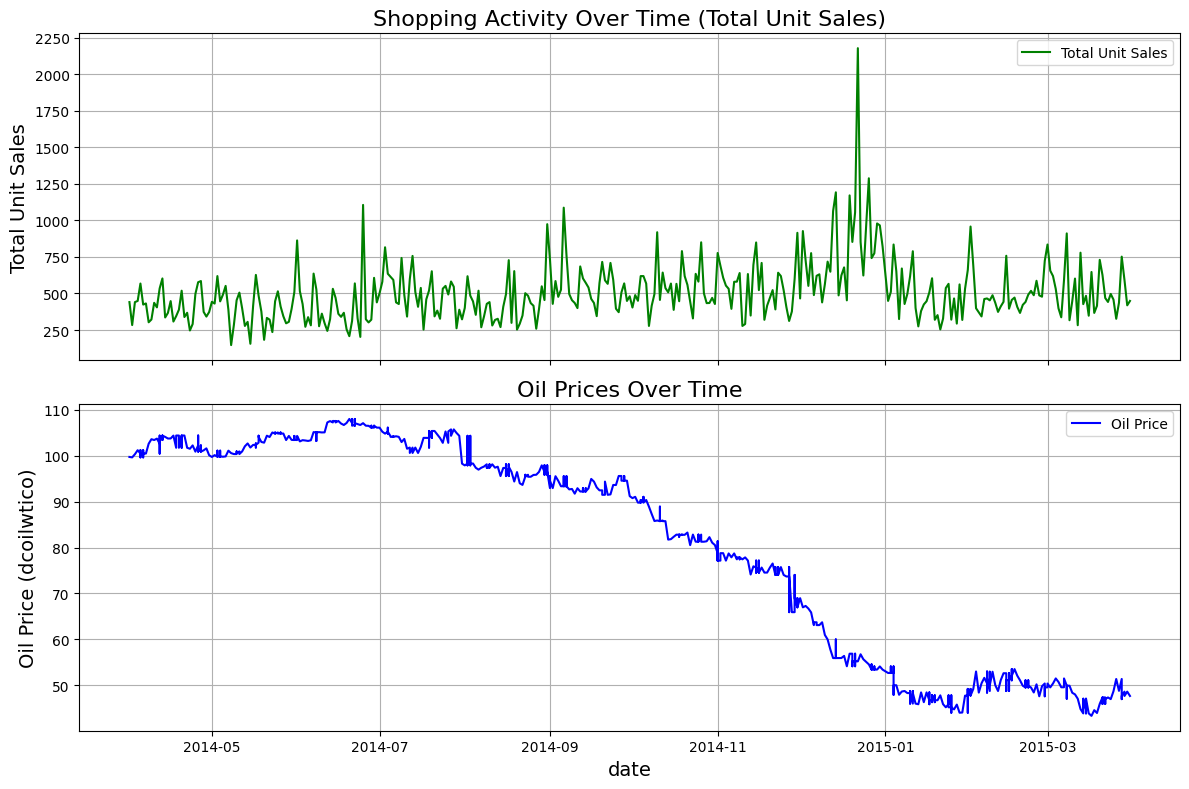

In [ ]:
df_sxg['date'] = pd.to_datetime(df_sxg['date'])

df_sxg = df_sxg.sort_values('date')

sales_per_day = df_sxg.groupby('date')['weighted_unit_sales'].sum()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

ax1.plot(sales_per_day.index, sales_per_day.values, color='green', label='Total Unit Sales')
ax1.set_title('Shopping Activity Over Time (Total Unit Sales)', fontsize=16)
ax1.set_ylabel('Total Unit Sales', fontsize=14)
ax1.legend()
ax1.grid(True)

ax2.plot(df_sxg['date'], df_sxg['dcoilwtico'], color='blue', label='Oil Price')
ax2.set_title('Oil Prices Over Time', fontsize=16)
ax2.set_xlabel('date', fontsize=14)
ax2.set_ylabel('Oil Price (dcoilwtico)', fontsize=14)
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

# XGBoost models

## simple XGBoost model

Create Lag Features

In [ ]:
# I will create lags on full dataset, then split again
df_lag = df_sxg[['date', 'weighted_unit_sales']].copy()

# Create lag features (1-day and 2-day lags)
df_lag['lag_1'] = df_lag['weighted_unit_sales'].shift(1)
df_lag['lag_2'] = df_lag['weighted_unit_sales'].shift(2)
df_lag['lag_3'] = df_lag['weighted_unit_sales'].shift(3)

Add Rolling Features (Optional but Helpful)

In [ ]:
df_lag['rolling_mean_7'] = df_lag['weighted_unit_sales'].rolling(window=7).mean() # Add Rolling Features to Full Dataset
df_lag['rolling_std_7'] = df_lag['weighted_unit_sales'].rolling(window=7).std()

Drop NaNs from Lags

In [ ]:
# Drop rows where lag values are NaN (only affects the first 3 rows)
df_lag.dropna(inplace=True)

Split Train/Test Again (after lags)

In [ ]:
split_date = '05-Jan-2014' # split such a way that it should not include holidays effect

In [ ]:
df_train = df_lag[df_lag['date'] <= split_date].copy() # Now apply the split again on df_lag
df_test = df_lag[df_lag['date'] > split_date].copy()

Now the df_lag has:


•          lag_1, lag_2, lag_3

•          rolling_mean_7, rolling_std_7

•          weighted_unit_sales (target)

Split Again (Final Time)

In [ ]:
df_train = df_lag[df_lag['date'] <= split_date].copy()
df_test = df_lag[df_lag['date'] > split_date].copy()

Define Features and Target

In [ ]:
feature_cols = ['lag_1', 'lag_2', 'lag_3', 'rolling_mean_7', 'rolling_std_7']

X_train = df_train[feature_cols]
y_train = df_train['weighted_unit_sales']

X_test = df_test[feature_cols]
y_test = df_test['weighted_unit_sales']

Fit XGBoost

In [ ]:
model = XGBRegressor(n_estimators=100, learning_rate=0.1) # Now XGBRegressor is properly imported and can be used.
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

Make Predictions

In [ ]:
y_pred = model.predict(X_test)

Plot Results

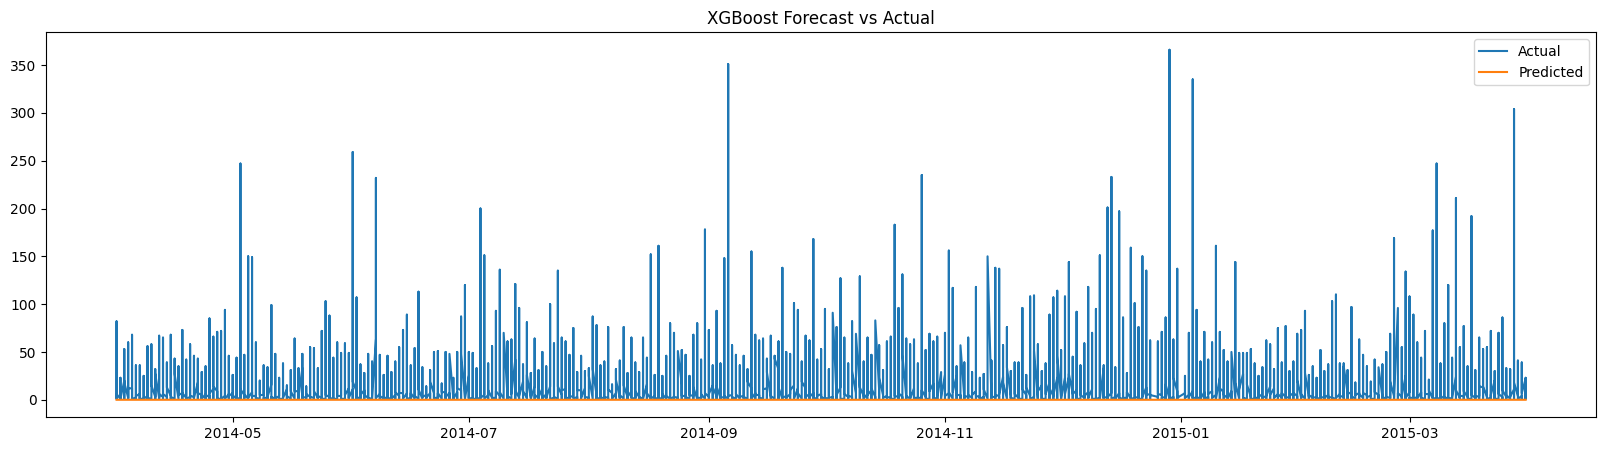

In [ ]:
plt.figure(figsize=(20, 5))
plt.plot(df_test['date'], y_test, label='Actual')
plt.plot(df_test['date'], y_pred, label='Predicted')
plt.legend()
plt.title('XGBoost Forecast vs Actual')
plt.show()

In [ ]:
print(f"Shape of df_test: {df_test.shape}")

print(f"Feature columns: {feature_cols}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")
print(f"y_pred shape: {y_pred.shape}")

Shape of df_test: (26301, 7)
Feature columns: ['lag_1', 'lag_2', 'lag_3', 'rolling_mean_7', 'rolling_std_7']
X_test shape: (26301, 5)
y_test shape: (26301,)
y_pred shape: (26301,)


In [ ]:
# Evaluation
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

# Print results
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")

MAE: 6.99
RMSE: 14.59
R²: -0.2977


In [ ]:
gc.collect() # rubbish collection

9919

## Step-by-step explanation of XGBRegressor

**1. What is XGBRegressor?**

	•	XGBRegressor is a machine learning model from the XGBoost library.

	•	It is used to predict numbers (regression),
  such as predicting house prices, oil prices, or sales.

	•	It works using something called boosted decision trees,
  which are just a bunch of smart questions put together to make a good prediction.

**2. What does n_estimators=100 mean?**

	•	This tells the model to build 100 small decision trees.

	•	Each new tree tries to fix the mistakes made by the previous ones.

	•	More trees can mean better predictions,
  but too many might also lead to overfitting (memorising instead of generalising).

**3. What does learning_rate=0.1 mean?**

	•	The learning rate controls how much each tree can change the prediction.

	•	A small number (like 0.1) means the model learns slowly and carefully.

	•	Lower learning rate = safer but may need more trees.

**4. What does model.fit(X_train, y_train) do?**

	•	This line trains (fits) the model using your training data.

	•	X_train is the input features (like income, location, oil price).

	•	y_train is what you’re trying to predict (like shopping amount).
  
	•	The model looks at this data and learns patterns.

**5. How is this tuning?**

	•	Model tuning means changing settings
  (called hyperparameters) like n_estimators and
  learning_rate to get better results.

	•	If the model predicts poorly, one can:

	•	Try more or fewer trees.

	•	Increase or decrease the learning rate.

	•	Try other parameters too (like max_depth, subsample, etc.).

**🔧 What Are Hyperparameters?**

	•	Hyperparameters are settings one chooses before training a machine learning model.

	•	They control how the model learns, not what it learns.

	•	Think of them like baking instructions (temperature, time)
  — they affect the final cake, even though the ingredients (the data) stay the same.

### 🔧 Common Hyperparameters in `XGBRegressor`

| Hyperparameter      | Description                                                                 | Example / Effect                                         |
|---------------------|-----------------------------------------------------------------------------|-----------------------------------------------------------|
| `n_estimators`      | Number of trees to build                                                    | Higher = more learning, but slower and risk of overfitting |
| `learning_rate`     | Step size shrinkage to prevent overfitting                                  | Lower = safer, needs more trees (e.g. 0.1, 0.01)           |
| `max_depth`         | Maximum depth of each tree                                                  | Higher = more complex model, more risk of overfitting     |
| `subsample`         | Fraction of training data used per tree                                     | 0.8 = 80% of data; helps prevent overfitting              |
| `colsample_bytree`  | Fraction of features used per tree                                          | 0.8 = 80% of features; reduces model complexity           |
| `gamma`             | Minimum loss reduction to make a further split                              | Higher = more conservative splits                         |
| `reg_alpha`         | L1 regularization term (encourages sparsity)                                | Useful for feature selection                              |
| `reg_lambda`        | L2 regularization term (reduces model complexity)                           | Helps prevent overfitting                                 |
| `min_child_weight`  | Minimum sum of instance weight (hessian) needed in a child                  | Higher = more conservative splits                         |
| `objective`         | Specifies the learning task (e.g. regression, classification)               | `reg:squarederror`, `binary:logistic`, etc.              |
| `booster`           | Type of boosting model to use                                               | `gbtree`, `gblinear`, `dart`                              |
| `tree_method`       | Algorithm used to grow trees                                                | `auto`, `hist`, `gpu_hist` (for GPU training)            |

In [ ]:
'''
from xgboost import XGBRegressor

# Basic example of applying hyperparameters:
# - n_estimators: number of trees (100)
# - learning_rate: how fast the model learns (0.1)

model = XGBRegressor(n_estimators=100, learning_rate=0.1)

# Fit the model to training data (learns from X_train to predict y_train)
model.fit(X_train, y_train)
'''

'\nfrom xgboost import XGBRegressor\n\n# Basic example of applying hyperparameters:\n# - n_estimators: number of trees (100)\n# - learning_rate: how fast the model learns (0.1)\n\nmodel = XGBRegressor(n_estimators=100, learning_rate=0.1)\n\n# Fit the model to training data (learns from X_train to predict y_train)\nmodel.fit(X_train, y_train)\n'

## XGBoost hyperparameters

In [ ]:
df_hxg = df_download.copy()

In [ ]:
xgb = XGBRegressor(objective='reg:squarederror', random_state=42) # Base model

In [ ]:
df_hxg.sample(2)

,unit_sales,store_nbr,item_nbr,onpromotion,dcoilwtico,transferred,item_class,transactions,weighted_unit_sales,date,...,year_scaled,city_Daule,city_Guayaquil,city_Libertad,city_Playas,city_nan,items_family_BEVERAGES,items_family_CLEANING,items_family_GROCERY I,items_family_nan
23679,1.0,27,371434,0,47.650002,0,1058,1359,1.0,2015-02-26,...,-2,1,0,0,0,0,0,0,1,0
18174,7.0,24,1143685,0,55.970001,0,1124,2897,7.0,2014-12-16,...,-3,0,1,0,0,0,1,0,0,0


In [ ]:
df_hxg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26307 entries, 0 to 26306
Data columns (total 24 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   unit_sales              26307 non-null  float32
 1   store_nbr               26307 non-null  int8   
 2   item_nbr                26307 non-null  int32  
 3   onpromotion             26307 non-null  int8   
 4   dcoilwtico              26307 non-null  float32
 5   transferred             26307 non-null  int8   
 6   item_class              26307 non-null  int16  
 7   transactions            26307 non-null  int16  
 8   weighted_unit_sales     26307 non-null  float32
 9   date                    26307 non-null  object 
 10  month                   26307 non-null  int8   
 11  day                     26307 non-null  int8   
 12  week                    26307 non-null  int8   
 13  day_of_week             26307 non-null  int8   
 14  year_scaled             26307 non-null

Create Lag Features

In [ ]:
# I will create lags on full dataset, then split again
df_lag = df_hxg[['date', 'weighted_unit_sales']].copy()

# Create lag features (1-day and 2-day lags)
df_lag['lag_1'] = df_lag['weighted_unit_sales'].shift(1)
df_lag['lag_2'] = df_lag['weighted_unit_sales'].shift(2)
df_lag['lag_3'] = df_lag['weighted_unit_sales'].shift(3)

Add Rolling Features (Optional but Helpful)

In [ ]:
df_lag['rolling_mean_7'] = df_lag['weighted_unit_sales'].rolling(window=7).mean() # Add Rolling Features to Full Dataset
df_lag['rolling_std_7'] = df_lag['weighted_unit_sales'].rolling(window=7).std()

Drop NaNs from Lags

In [ ]:
# Drop rows where lag values are NaN (only affects the first 3 rows)
df_lag.dropna(inplace=True)

Split Train/Test Again (after lags)

In [ ]:
split_date = '05-Jan-2014' # split such a way that it should not include holidays effect

In [ ]:
df_train = df_lag[df_lag['date'] <= split_date].copy() # Now apply the split again on df_lag
df_test = df_lag[df_lag['date'] > split_date].copy()

Split Again (Final Time)

In [ ]:
df_train = df_lag[df_lag['date'] <= split_date].copy()
df_test = df_lag[df_lag['date'] > split_date].copy()

Define Features and Target

In [ ]:
feature_cols = ['lag_1', 'lag_2', 'lag_3', 'rolling_mean_7', 'rolling_std_7']

X_train = df_train[feature_cols]
y_train = df_train['weighted_unit_sales']

X_test = df_test[feature_cols]
y_test = df_test['weighted_unit_sales']

Fit XGBoost

In [ ]:
'''
model = XGBRegressor(n_estimators=100, learning_rate=0.1) # Now XGBRegressor is properly imported and can be used.
model.fit(X_train, y_train)
'''

'\nmodel = XGBRegressor(n_estimators=100, learning_rate=0.1) # Now XGBRegressor is properly imported and can be used.\nmodel.fit(X_train, y_train)\n'

Why?

	•	That model is just a basic/default one.
	•	It’s not using the hyperparameters we’re now tuning with Hyperopt.
	•	If you leave it in your code, it might:
	•	Confuse you with extra output.
	•	Accidentally overwrite your tuned model later.


Step 1: Set up the data properly

In [ ]:
# Assume df_sxg is the original DataFrame with 'date' and 'weighted_unit_sales'

df_lag = df_sxg[['date', 'weighted_unit_sales']].copy()

# Create lag and rolling features
df_lag['lag_1'] = df_lag['weighted_unit_sales'].shift(1)
df_lag['lag_2'] = df_lag['weighted_unit_sales'].shift(2)
df_lag['lag_3'] = df_lag['weighted_unit_sales'].shift(3)
df_lag['rolling_mean_7'] = df_lag['weighted_unit_sales'].rolling(window=7).mean()

# Drop rows with NaN due to lag/rolling
df_lag.dropna(inplace=True)

# Train-test split
split_date = '2014-01-05'
df_train = df_lag[df_lag['date'] <= split_date].copy()
df_test = df_lag[df_lag['date'] > split_date].copy()

# Features and target
feature_cols = ['lag_1', 'lag_2', 'lag_3', 'rolling_mean_7']
X_train = df_train[feature_cols]
y_train = df_train['weighted_unit_sales']
X_test = df_test[feature_cols]
y_test = df_test['weighted_unit_sales']

Step 2: Set up Hyperopt search space

In [ ]:
space = {
    'max_depth': hp.quniform('max_depth', 3, 18, 1),
    'gamma': hp.uniform('gamma', 0, 5),
    'reg_alpha': hp.quniform('reg_alpha', 0, 100, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
    'n_estimators': 180  # fixed for now
} # define a dictionary of parameters that we want Hyperopt to search through

Step 3: Define the objective function

In [ ]:
def objective(space):
    model = XGBRegressor(
        n_estimators=space['n_estimators'],
        max_depth=int(space['max_depth']),
        gamma=space['gamma'],
        reg_alpha=int(space['reg_alpha']),
        reg_lambda=space['reg_lambda'],
        colsample_bytree=space['colsample_bytree'],
        min_child_weight=int(space['min_child_weight']),
        learning_rate=space['learning_rate'],
        objective='reg:squarederror',
        seed=42
    )

    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)

    print("R²:", r2)
    return {'loss': -r2, 'status': STATUS_OK} # This is where the model is trained and evaluated.
    # XGBRegressor, and evaluating with R², since this is regression.

	•minimizing -R² so Hyperopt can maximize R²

	•can later switch this to RMSE or MAE if desired

Step 4: Run the Hyperopt optimizer

In [ ]:
from hyperopt import fmin, tpe, Trials

trials = Trials()

best = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=50,
    trials=trials
)

print("Best parameters:", best)

R²:
-0.2976958751678467
R²:
-0.2976958751678467
R²:
-0.2976958751678467
R²:
-0.2976958751678467
R²:
-0.2976958751678467
R²:
-0.2976958751678467
R²:
-0.2976958751678467
R²:
-0.2976958751678467
R²:
-0.2976958751678467
R²:
-0.2976958751678467
R²:
-0.2976958751678467
R²:
-0.2976958751678467
R²:
-0.2976958751678467
R²:
-0.2976958751678467
R²:
-0.2976958751678467
R²:
-0.2976958751678467
R²:
-0.2976958751678467
R²:
-0.2976958751678467
R²:
-0.2976958751678467
R²:
-0.2976958751678467
R²:
-0.2976958751678467
R²:
-0.2976958751678467
R²:
-0.2976958751678467
R²:
-0.2976958751678467
R²:
-0.2976958751678467
R²:
-0.2976958751678467
R²:
-0.2976958751678467
R²:
-0.2976958751678467
R²:
-0.2976958751678467
R²:
-0.2976958751678467
R²:
-0.2976958751678467
R²:
-0.2976958751678467
R²:
-0.2976958751678467
R²:
-0.2976958751678467
R²:
-0.2976958751678467
R²:
-0.2976958751678467
R²:
-0.2976958751678467
R²:
-0.2976958751678467
R²:
-0.2976958751678467
R²:
-0.2976958751678467
R²:
-0.2976958751678467
R²:
-0.297695875

	•	Try 50 combinations of hyperparameters.
	•	Train models and evaluate R².
	•	Return the best parameter set.

🔁 Recap of What was done:

	•	✅ Built lag & rolling features.
	•	✅ Split time series data.
	•	✅ Defined XGBoost model for regression.
	•	✅ Tuned key parameters using Hyperopt + R² score.

### Step-by-Step: Apply the Trained Model

In [ ]:
print("Best parameters:", best) # Get the best parameters from Hyperopt

Best parameters: {'colsample_bytree': np.float64(0.5572006277436716), 'gamma': np.float64(3.9752749564963423), 'learning_rate': np.float64(0.04789752535829521), 'max_depth': np.float64(13.0), 'min_child_weight': np.float64(5.0), 'reg_alpha': np.float64(75.0), 'reg_lambda': np.float64(0.2284369432897836)}


In [ ]:
best_params = {
    'n_estimators': 180,
    'max_depth': int(best['max_depth']),
    'gamma': best['gamma'],
    'reg_alpha': int(best['reg_alpha']),
    'reg_lambda': best['reg_lambda'],
    'colsample_bytree': best['colsample_bytree'],
    'min_child_weight': int(best['min_child_weight']),
    'learning_rate': best['learning_rate'],
    'objective': 'reg:squarederror',
    'seed': 42
} # some values like max_depth, reg_alpha, etc., need to be converted from float to int

Train final model with best params

In [ ]:
final_model = XGBRegressor(**best_params)
final_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=np.float64(0.5572006277436716), device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None,
             gamma=np.float64(3.9752749564963423), grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=np.float64(0.04789752535829521), max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=13, max_leaves=None,
             min_child_weight=5, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=180, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

Make predictions and evaluate

In [ ]:
y_pred = final_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")

MAE: 6.99
RMSE: 14.59
R²: -0.2977


Optional

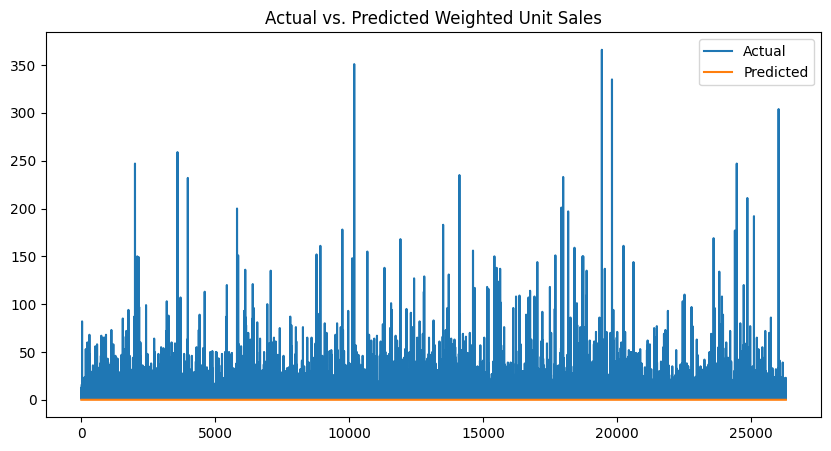

In [ ]:
plt.figure(figsize=(10,5)) # Plot actual vs. predicted (simple and useful)
plt.plot(y_test.values, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.title('Actual vs. Predicted Weighted Unit Sales')
plt.show()

In [ ]:
gc.collect() # rubbish collection

## Save XGBoost Model to Google Drive

In [ ]:
'''
from google.colab import drive
drive.mount('/content/drive')
'''

Create a folder (optional)

In [ ]:
# import os

model_path = '/content/drive/MyDrive/MasterSchool/MasterSchool_Python/Time_Series/Time_series_project/xgboost_models'
os.makedirs(model_path, exist_ok=True)

Save the trained model

In [ ]:
# import joblib

# Save model
joblib.dump(final_model, model_path + '/xgb_final_model.pkl')

['/content/drive/MyDrive/MasterSchool/MasterSchool_Python/Time_Series/Time_series_project/xgboost_models/xgb_final_model.pkl']

Later, load the model like this

In [ ]:
# Load model
loaded_model = joblib.load(model_path + '/xgb_final_model.pkl')

# Use it to predict
y_pred_loaded = loaded_model.predict(X_test)

'/content/drive/My Drive/xgboost_models/xgb_final_model.pkl'

### Step-by-step Usage of Your Saved XGBoost Model

In [ ]:
'''
from google.colab import drive
drive.mount('/content/drive')
'''

"\nfrom google.colab import drive\ndrive.mount('/content/drive')\n"

Load your trained model

In [ ]:
# import joblib # Make sure joblib is imported if you've commented it out

model_path = '/content/drive/MyDrive/MasterSchool/MasterSchool_Python/Time_Series/Time_series_project/xgboost_models/xgb_final_model.pkl'  # Add the filename
model = joblib.load(model_path) # Now joblib.load() should find the pickle file

Prepare new data for prediction

In [ ]:
df_future = df_download.copy()

In [ ]:
# Assume df_future is your new DataFrame
df_future['lag_1'] = df_future['weighted_unit_sales'].shift(1)
df_future['lag_2'] = df_future['weighted_unit_sales'].shift(2)
df_future['lag_3'] = df_future['weighted_unit_sales'].shift(3)
df_future['rolling_mean_7'] = df_future['weighted_unit_sales'].rolling(window=7).mean()
df_future.dropna(inplace=True)

X_new = df_future[['lag_1', 'lag_2', 'lag_3', 'rolling_mean_7']]

Predict using the loaded model

In [ ]:
predictions = model.predict(X_new)

Add predictions back to the DataFrame

In [ ]:
df_future['predicted_sales'] = predictions

In [ ]:
y_pred = loaded_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")

MAE: 6.99
RMSE: 14.59
R²: -0.2977


In [ ]:
'''
  Load & Evaluate Saved Model

from google.colab import drive
import joblib
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Step 1: Mount Drive (if not already)
drive.mount('/content/drive')

# Step 2: Load the model
model_path = '/content/drive/My Drive/xgboost_models/xgb_final_model.pkl'
loaded_model = joblib.load(model_path)

# Step 3: Predict using loaded model
y_pred = loaded_model.predict(X_test)

# Step 4: Evaluate
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")
'''

'\n  Load & Evaluate Saved Model\n\nfrom google.colab import drive\nimport joblib\nfrom sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score\nimport numpy as np\n\n# Step 1: Mount Drive (if not already)\ndrive.mount(\'/content/drive\')\n\n# Step 2: Load the model\nmodel_path = \'/content/drive/My Drive/xgboost_models/xgb_final_model.pkl\'\nloaded_model = joblib.load(model_path)\n\n# Step 3: Predict using loaded model\ny_pred = loaded_model.predict(X_test)\n\n# Step 4: Evaluate\nmae = mean_absolute_error(y_test, y_pred)\nrmse = np.sqrt(mean_squared_error(y_test, y_pred))\nr2 = r2_score(y_test, y_pred)\n\nprint(f"MAE: {mae:.2f}")\nprint(f"RMSE: {rmse:.2f}")\nprint(f"R²: {r2:.4f}")\n'